src= https://www.kaggle.com/datasets/sandeep1080/used-car-sales/code

25 columns
title : used-car-sales

In [ ]:
!pip install pip==23.2.1 setuptools==65.5.1

In [ ]:
!pip install deap  pyswarm pywhale xgboost matplotlib lightgbm catboost imbalanced-learn

In [ ]:
# connect S3 bucket
bucket = "mscproject01"
datakey = "vehicles.csv"
data_location = f"s3://{bucket}/{datakey}"

print(data_location)

s3://mscproject01/vehicles.csv


In [ ]:
# import the library

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from deap import base, creator, tools, algorithms
import random

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.preprocessing import MinMaxScaler
import time

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


In [ ]:
# Load dataset
df = pd.read_csv(data_location)
df.head(5)

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/fsspec/registry.py:283: UserWarning: Your installed version of s3fs is very old and known to cause
severe performance issues, see also https://github.com/dask/dask/issues/10276

To fix, you should specify a lower version bound on s3fs, or
update the current installation.

  warnings.warn(s3_msg)


,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
0,7222695916,https://prescott.craigslist.org/cto/d/prescott...,prescott,https://prescott.craigslist.org,6000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,az,NaN,NaN,NaN
1,7218891961,https://fayar.craigslist.org/ctd/d/bentonville...,fayetteville,https://fayar.craigslist.org,11900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ar,NaN,NaN,NaN
2,7221797935,https://keys.craigslist.org/cto/d/summerland-k...,florida keys,https://keys.craigslist.org,21000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,fl,NaN,NaN,NaN
3,7222270760,https://worcester.craigslist.org/cto/d/west-br...,worcester / central MA,https://worcester.craigslist.org,1500,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ma,NaN,NaN,NaN
4,7210384030,https://greensboro.craigslist.org/cto/d/trinit...,greensboro,https://greensboro.craigslist.org,4900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,nc,NaN,NaN,NaN


In [ ]:
df.shape

(426880, 26)

In [ ]:
df.columns

Index(['id', 'url', 'region', 'region_url', 'price', 'year', 'manufacturer',
       'model', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status',
       'transmission', 'VIN', 'drive', 'size', 'type', 'paint_color',
       'image_url', 'description', 'county', 'state', 'lat', 'long',
       'posting_date'],
      dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 26 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   url           426880 non-null  object 
 2   region        426880 non-null  object 
 3   region_url    426880 non-null  object 
 4   price         426880 non-null  int64  
 5   year          425675 non-null  float64
 6   manufacturer  409234 non-null  object 
 7   model         421603 non-null  object 
 8   condition     252776 non-null  object 
 9   cylinders     249202 non-null  object 
 10  fuel          423867 non-null  object 
 11  odometer      422480 non-null  float64
 12  title_status  418638 non-null  object 
 13  transmission  424324 non-null  object 
 14  VIN           265838 non-null  object 
 15  drive         296313 non-null  object 
 16  size          120519 non-null  object 
 17  type          334022 non-null  object 
 18  pain

In [ ]:
df.duplicated().sum()

0

In [ ]:
df.isnull().sum()

id                   0
url                  0
region               0
region_url           0
price                0
year              1205
manufacturer     17646
model             5277
condition       174104
cylinders       177678
fuel              3013
odometer          4400
title_status      8242
transmission      2556
VIN             161042
drive           130567
size            306361
type             92858
paint_color     130203
image_url           68
description         70
county          426880
state                0
lat               6549
long              6549
posting_date        68
dtype: int64

In [ ]:
# Drop column where all values are null
df.drop(columns=['county'], inplace=True)


In [ ]:
# Fill with mode for categorical, median/mean for numerical
df['year'].fillna(df['year'].median(), inplace=True)
df['fuel'].fillna(df['fuel'].mode()[0], inplace=True)
df['odometer'].fillna(df['odometer'].median(), inplace=True)


In [ ]:
threshold = 0.5
df = df.loc[:, df.isnull().mean() < threshold]

In [ ]:
# Fill common categorical columns with mode
for col in ['manufacturer', 'model', 'title_status', 'transmission', 'drive']:
    df[col].fillna(df[col].mode()[0], inplace=True)

# Fill remaining high-missing categorical with "unknown"
for col in ['condition', 'cylinders', 'type', 'paint_color']:
    df[col].fillna('unknown', inplace=True)

# Drop VIN if not used in modeling
df.drop(columns=['VIN'], inplace=True)

# Drop rows with minor missing (image_url, description, posting_date, lat/long)
df.dropna(subset=['image_url', 'description', 'posting_date', 'lat', 'long'], inplace=True)


In [ ]:
df.isnull().sum()

id              0
url             0
region          0
region_url      0
price           0
year            0
manufacturer    0
model           0
condition       0
cylinders       0
fuel            0
odometer        0
title_status    0
transmission    0
drive           0
type            0
paint_color     0
image_url       0
description     0
state           0
lat             0
long            0
posting_date    0
dtype: int64

In [ ]:
df.shape

(420329, 23)

In [ ]:
df.columns

Index(['id', 'url', 'region', 'region_url', 'price', 'year', 'manufacturer',
       'model', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status',
       'transmission', 'drive', 'type', 'paint_color', 'image_url',
       'description', 'state', 'lat', 'long', 'posting_date'],
      dtype='object')

In [ ]:
df.drop(columns=['id', 'url', 'region_url', 'image_url','description','posting_date'], inplace=True)

In [ ]:
df.tail()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,lat,long
426875,wyoming,23590,2019.0,nissan,maxima s sedan 4d,good,6 cylinders,gas,32226.0,clean,other,fwd,sedan,unknown,wy,33.786500,-84.445400
426876,wyoming,30590,2020.0,volvo,s60 t5 momentum sedan 4d,good,unknown,gas,12029.0,clean,other,fwd,sedan,red,wy,33.786500,-84.445400
426877,wyoming,34990,2020.0,cadillac,xt4 sport suv 4d,good,unknown,diesel,4174.0,clean,other,4wd,hatchback,white,wy,33.779214,-84.411811
426878,wyoming,28990,2018.0,lexus,es 350 sedan 4d,good,6 cylinders,gas,30112.0,clean,other,fwd,sedan,silver,wy,33.786500,-84.445400
426879,wyoming,30590,2019.0,bmw,4 series 430i gran coupe,good,unknown,gas,22716.0,clean,other,rwd,coupe,unknown,wy,33.779214,-84.411811


In [ ]:
df['year'] = df['year'].astype(int)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 420329 entries, 27 to 426879
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   region        420329 non-null  object 
 1   price         420329 non-null  int64  
 2   year          420329 non-null  int64  
 3   manufacturer  420329 non-null  object 
 4   model         420329 non-null  object 
 5   condition     420329 non-null  object 
 6   cylinders     420329 non-null  object 
 7   fuel          420329 non-null  object 
 8   odometer      420329 non-null  float64
 9   title_status  420329 non-null  object 
 10  transmission  420329 non-null  object 
 11  drive         420329 non-null  object 
 12  type          420329 non-null  object 
 13  paint_color   420329 non-null  object 
 14  state         420329 non-null  object 
 15  lat           420329 non-null  float64
 16  long          420329 non-null  float64
dtypes: float64(3), int64(2), object(12)
memory usag

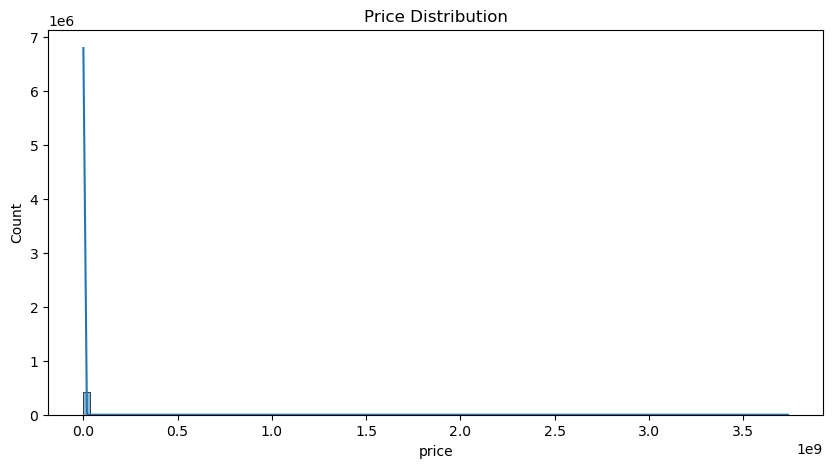

count    4.203290e+05
mean     7.619384e+04
std      1.227685e+07
min      0.000000e+00
25%      5.990000e+03
50%      1.398800e+04
75%      2.659000e+04
max      3.736929e+09
Name: price, dtype: float64


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.histplot(df['price'], bins=100, kde=True)
plt.title("Price Distribution")
plt.show()

print(df['price'].describe())


In [ ]:
df = df[(df['price'] > 0) & (df['price'] <= 50000)]

In [ ]:
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)]


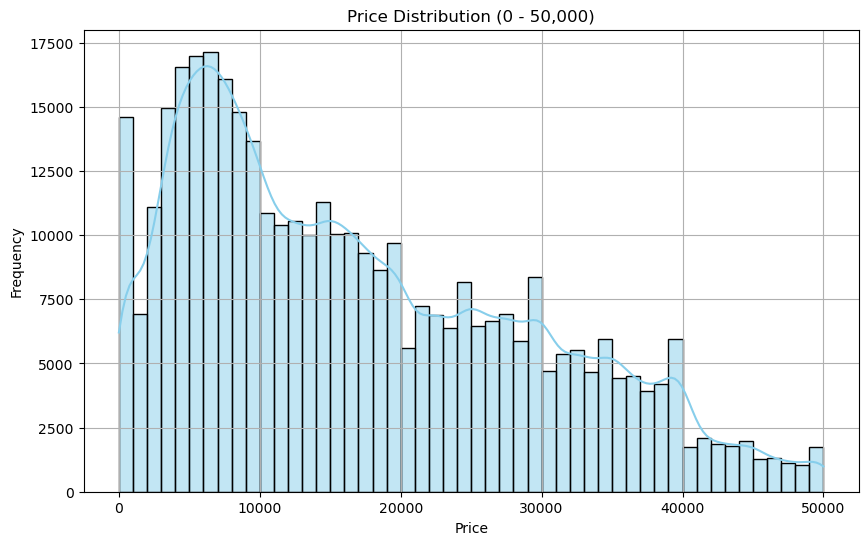

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(df['price'], bins=50, kde=True, color='skyblue')
plt.title('Price Distribution (0 - 50,000)')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


count    377598.000000
mean      17254.099055
std       12196.552707
min           1.000000
25%        6995.000000
50%       14900.000000
75%       25995.000000
max       50000.000000
Name: price, dtype: float64


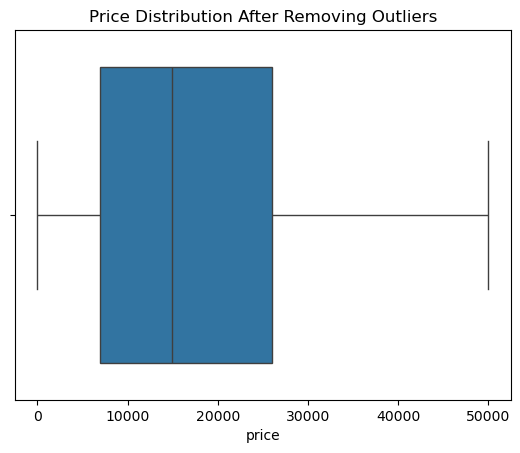

In [ ]:
print(df['price'].describe())
sns.boxplot(x=df['price'])
plt.title("Price Distribution After Removing Outliers")
plt.show()


In [ ]:
from sklearn.preprocessing import LabelEncoder

categorical_columns = df.select_dtypes(include=['object']).columns
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

print("✅ Preprocessing complete. Here's a preview:")
print(df.head())


✅ Preprocessing complete. Here's a preview:
    region  price  year  manufacturer  model  condition  cylinders  fuel  \
27      16  33590  2014            14  22284          2          6     2   
28      16  22590  2010             7  22581          2          6     2   
29      16  39590  2020             7  22623          2          6     2   
30      16  30990  2017            39  25387          2          6     2   
31      16  15000  2013            13  13318          0          5     2   

    odometer  title_status  transmission  drive  type  paint_color  state  \
27   57923.0             0             2      0     8           11      1   
28   71229.0             0             2      0     8            1      1   
29   19160.0             0             2      0     8            8      1   
30   41124.0             0             2      0     8            8      1   
31  128000.0             0             0      2    10            0      1   

       lat     long  
27  32.590 -85

In [ ]:
# Separate target and features
y = df['price']
X = df.drop(columns=['price'])

print("✅ Target and features are ready!")
print("🎯 y (target):", y.name)
print("🧠 X shape:", X.shape)


✅ Target and features are ready!
🎯 y (target): price
🧠 X shape: (377598, 16)


In [ ]:
from sklearn.model_selection import train_test_split

# 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("✅ Data split complete!")
print("🧪 X_train shape:", X_train.shape)
print("🧪 X_test shape :", X_test.shape)
print("🎯 y_train shape:", y_train.shape)
print("🎯 y_test shape :", y_test.shape)


✅ Data split complete!
🧪 X_train shape: (302078, 16)
🧪 X_test shape : (75520, 16)
🎯 y_train shape: (302078,)
🎯 y_test shape : (75520,)


In [ ]:
models = {
    "XGBoost": {
        "model": XGBRegressor(tree_method="hist", random_state=42),  # Remove device="cuda"
        "params": {
            "n_estimators": [100, 200],
            "max_depth": [4, 6],
            "learning_rate": [0.01, 0.1]
        }
    },
    "LightGBM": {
        "model": LGBMRegressor(random_state=42),  # Remove device_type="gpu"
        "params": {
            "n_estimators": [100, 200],
            "max_depth": [4, 6],
            "learning_rate": [0.01, 0.1]
        }
    },
    "Random Forest": {
        "model": RandomForestRegressor(random_state=42),
        "params": {
            "n_estimators": [100, 200],
            "max_depth": [4, 6]
        }
    },
    "HistGradientBoosting": {
        "model": HistGradientBoostingRegressor(random_state=42),
        "params": {
            "max_iter": [100, 200],  # Note: parameter name is max_iter, not n_estimators
            "max_depth": [4, 6],
            "learning_rate": [0.01, 0.1]
        }
    },
    "CatBoost": {
        "model": CatBoostRegressor(verbose=0, random_state=42),  # Remove task_type="GPU"
        "params": {
            "iterations": [100, 200],
            "depth": [4, 6],
            "learning_rate": [0.01, 0.1]
        }
    }
}

In [ ]:
# Train & evaluate models
results = {}
for name, config in models.items():
    print(f"\n=== Tuning {name} ===")

    # GridSearchCV for best hyperparameters
    grid = GridSearchCV(
        estimator=config["model"],
        param_grid=config["params"],
        cv=3,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )

    start_time = time.time()
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_

    # Predict & evaluate
    y_pred = best_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)

    # Store results
    results[name] = {
        "Best Params": grid.best_params_,
        "MSE": mse,
        "Time (s)": round(time.time() - start_time, 2)
    }

    print(f"Best Params: {grid.best_params_}")
    print(f"MSE: {mse:.4f}")
    print(f"Training Time: {results[name]['Time (s)']}s")

# Display final results
print("\n=== Model Performance Summary ===")
results_df = pd.DataFrame(results).T
# Sort the models by MSE and display the performance
print(results_df[['MSE', 'Time (s)']].sort_values('MSE'))


=== Tuning XGBoost ===


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinu

Best Params: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200}
MSE: 25820808.0000
Training Time: 9.9s

=== Tuning LightGBM ===
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.067985 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1512
[LightGBM] [Info] Number of data points in the train set: 201385, number of used features: 16
[LightGBM] [Info] Start training from score 17276.982769
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinu

Best Params: {'depth': 6, 'iterations': 200, 'learning_rate': 0.1}
MSE: 35661014.5367
Training Time: 47.9s

=== Model Performance Summary ===
                                  MSE Time (s)
XGBoost                    25820808.0      9.9
LightGBM              27915802.610687    28.81
HistGradientBoosting  28248349.842135     10.9
CatBoost              35661014.536712     47.9
Random Forest         61988193.827641   274.19


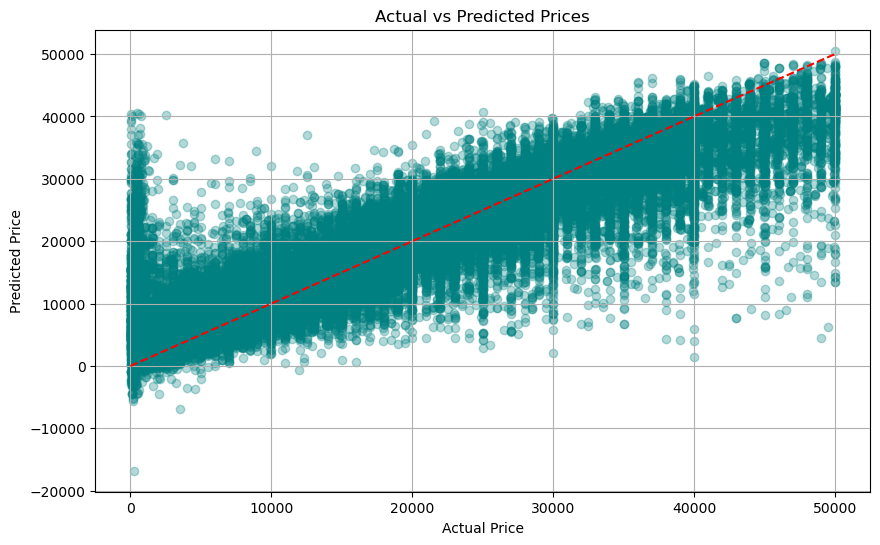

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034431 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1512
[LightGBM] [Info] Number of data points in the train set: 201385, number of used features: 16
[LightGBM] [Info] Start training from score 17276.982769
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

In [ ]:
# Train XGBoost model (using the best hyperparameters found during tuning)
best_params = {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200}
xgboost_model = XGBRegressor(**best_params)
xgboost_model.fit(X_train, y_train)

# Now, make predictions
y_pred = xgboost_model.predict(X_test)


import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3, color='teal')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Prices')
plt.grid(True)
plt.show()

